<a href="https://colab.research.google.com/github/Diksha-kumari-singh/ERA5-Rainfall-Prediction-Model/blob/main/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diksha kumari
2352144

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. Raw Data: Load ERA5 NetCDF data ---
# Replace 'your_era5_file.nc' with the path to your downloaded ERA5 file.
# The ERA5 dataset contains variables like 'tp' (total precipitation) and 't2m' (2m temperature).
try:
    ds = xr.open_dataset('accum.nc')
    df = ds.to_dataframe().reset_index()
    print("ERA5 dataset loaded successfully.")
    print("DataFrame shape:", df.shape)
except FileNotFoundError:
    print("Error: ERA5 data file 'accum.nc' not found.")
    print("Please download it from the Copernicus Climate Data Store and place it in the working directory.")
    exit()

ERA5 dataset loaded successfully.
DataFrame shape: (170586, 6)



--- EDA: Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170586 entries, 0 to 170585
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   latitude       170586 non-null  float64
 1   longitude      170586 non-null  float64
 2   precipitation  170586 non-null  float32
dtypes: float32(1), float64(2)
memory usage: 3.3 MB
None

--- Null Value Check ---
latitude         0
longitude        0
precipitation    0
dtype: int64


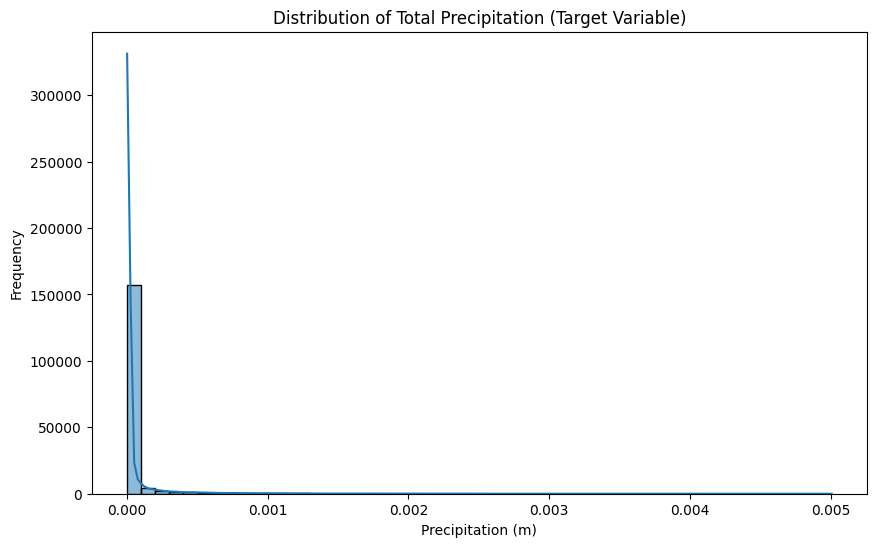

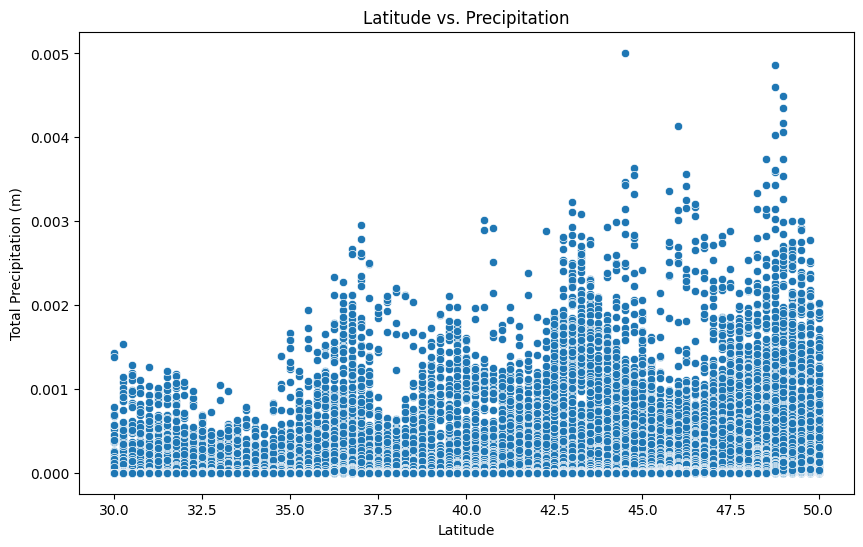

In [7]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- EDA: Data Information ---")
print(df.info())

# Check for null values
print("\n--- Null Value Check ---")
print(df.isnull().sum())

# Drop rows with any missing values, as they can cause issues.
df.dropna(inplace=True)

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['precipitation'], bins=50, kde=True)
plt.title('Distribution of Total Precipitation (Target Variable)')
plt.xlabel('Precipitation (m)')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between features and the target
# This is a conceptual example for one feature. You'd do this for others.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='precipitation', data=df)
plt.title('Latitude vs. Precipitation')
plt.xlabel('Latitude')
plt.ylabel('Total Precipitation (m)')
plt.show()

In [9]:
# --- 3. Train-Test Split ---
# Define features (X) and target (y)
# The features are all columns except 'precipitation'
X = df.drop('precipitation', axis=1)
y = df['precipitation']

# Handle any potential categorical features if they exist (e.g., 'date')
# For ERA5 data, you might want to extract features from the date (e.g., month, day).
# Assuming 'time' is an index level, if not, you'd need to adjust
# X['month'] = X.index.get_level_values('time').month
# X['dayofyear'] = X.index.get_level_values('time').dayofyear

# Drop the original non-numeric index columns
# X = X.reset_index().drop(['time', 'latitude', 'longitude'], axis=1, errors='ignore')


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training and testing sets.")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Data split into training and testing sets.
Training set size: 136468
Testing set size: 34118


In [10]:
# --- 4 & 5. Preprocessing & Feature Extraction/Selection ---
# We'll use a ColumnTransformer with StandardScaler for numerical features.
# The pipeline handles scaling and model training sequentially.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ])

# --- 6, 7 & 9. ML Algorithms, Hyperparameter Tuning & Evaluation ---
# We will use a dictionary to define multiple regression models and their hyperparameters.
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters to tune for simple linear regression
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'regressor__alpha': [0.1, 1.0, 10.0]}
    },
    'Random Forest Regressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'regressor__n_estimators': [50, 100, 200], 'regressor__max_depth': [5, 10, None]}
    },
}

best_models = {}
evaluation_metrics = {}

print("\n--- Training and Evaluating Individual Models with Hyperparameter Tuning ---")
for name, config in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', config['model'])])

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    y_pred = best_models[name].predict(X_test)

    # Evaluate the best model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    evaluation_metrics[name] = {
        'Best Parameters': grid_search.best_params_,
        'R-squared (R2)': r2,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'Mean Absolute Error (MAE)': mae
    }

    print(f"\n--- Metrics for {name} ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"R-squared: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


--- Training and Evaluating Individual Models with Hyperparameter Tuning ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits

--- Metrics for Linear Regression ---
Best Parameters: {}
R-squared: 0.0224
MSE: 0.0000
RMSE: 0.0002
MAE: 0.0001
Fitting 5 folds for each of 3 candidates, totalling 15 fits

--- Metrics for Ridge Regression ---
Best Parameters: {'regressor__alpha': 10.0}
R-squared: 0.0224
MSE: 0.0000
RMSE: 0.0002
MAE: 0.0001
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Metrics for Random Forest Regressor ---
Best Parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 100}
R-squared: 0.0463
MSE: 0.0000
RMSE: 0.0002
MAE: 0.0001



--- Designing Ensemble Technique (VotingRegressor) ---

--- Final Comparative Analysis ---
                                                           Best Parameters  \
Linear Regression                                                       {}   
Ridge Regression                                {'regressor__alpha': 10.0}   
Random Forest Regressor  {'regressor__max_depth': 5, 'regressor__n_esti...   
Ensemble Model                                                         N/A   

                        R-squared (R2) Mean Squared Error (MSE)  \
Linear Regression             0.022355                      0.0   
Ridge Regression              0.022355                      0.0   
Random Forest Regressor       0.046266                      0.0   
Ensemble Model                0.035384                      0.0   

                        Root Mean Squared Error (RMSE)  \
Linear Regression                             0.000191   
Ridge Regression                              0.000191   
Random 

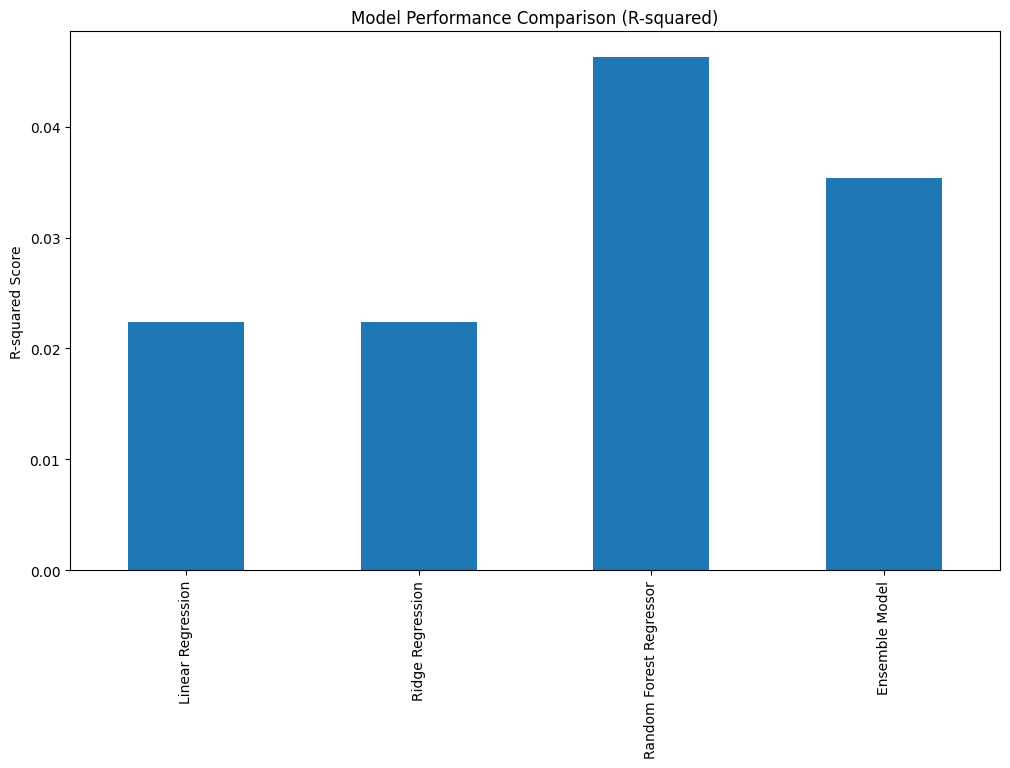

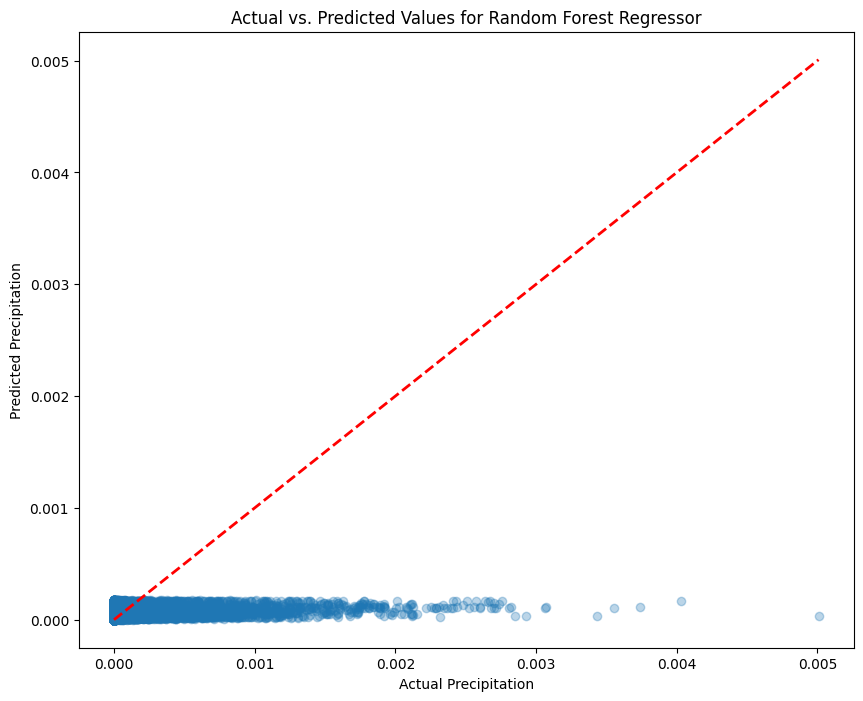


Conclusion: The best performing model is the Random Forest Regressor with an R-squared score of 0.0463.


In [11]:
# --- 10. Design Ensemble Technique ---
# We'll use a VotingRegressor to combine the best performing models.
# The 'weights' can be adjusted based on the performance of each model.
print("\n--- Designing Ensemble Technique (VotingRegressor) ---")
ensemble_regressor = VotingRegressor(
    estimators=[(name, model) for name, model in best_models.items()],
    n_jobs=-1
)

ensemble_regressor.fit(X_train, y_train)
y_pred_ensemble = ensemble_regressor.predict(X_test)

# --- 9 & 11. Evaluate and Compare Ensemble Model ---
ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
ensemble_mae = mean_absolute_error(y_test, y_pred_ensemble)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test, y_pred_ensemble)

evaluation_metrics['Ensemble Model'] = {
    'Best Parameters': 'N/A', # Not applicable for VotingRegressor in this setup
    'R-squared (R2)': ensemble_r2,
    'Mean Squared Error (MSE)': ensemble_mse,
    'Root Mean Squared Error (RMSE)': ensemble_rmse,
    'Mean Absolute Error (MAE)': ensemble_mae
}

# --- Final Comparative Analysis ---
print("\n--- Final Comparative Analysis ---")
results_df = pd.DataFrame(evaluation_metrics).T
print(results_df)

# Plotting the comparison of R-squared scores
results_df['R-squared (R2)'].plot(kind='bar', figsize=(12, 7), title='Model Performance Comparison (R-squared)')
plt.ylabel('R-squared Score')
plt.show()

# Plotting actual vs. predicted values for the best model
best_model_name = results_df['R-squared (R2)'].idxmax()
best_model = best_models[best_model_name]
y_pred_best_model = best_model.predict(X_test)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best_model, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs. Predicted Values for {best_model_name}')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.show()

print(f"\nConclusion: The best performing model is the {best_model_name} with an R-squared score of {results_df.loc[best_model_name, 'R-squared (R2)']:.4f}.")